In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
from jax import jit
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import scipy
# import optax
from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True)

### Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 3
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 100100100


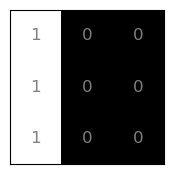

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

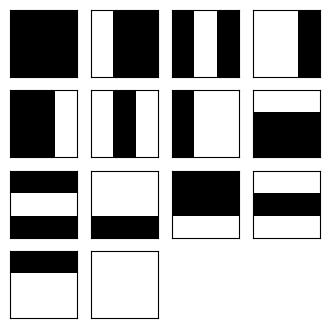

In [4]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [5]:
bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
print(nums)

[0, 292, 146, 438, 73, 365, 219, 448, 56, 504, 7, 455, 63, 511]


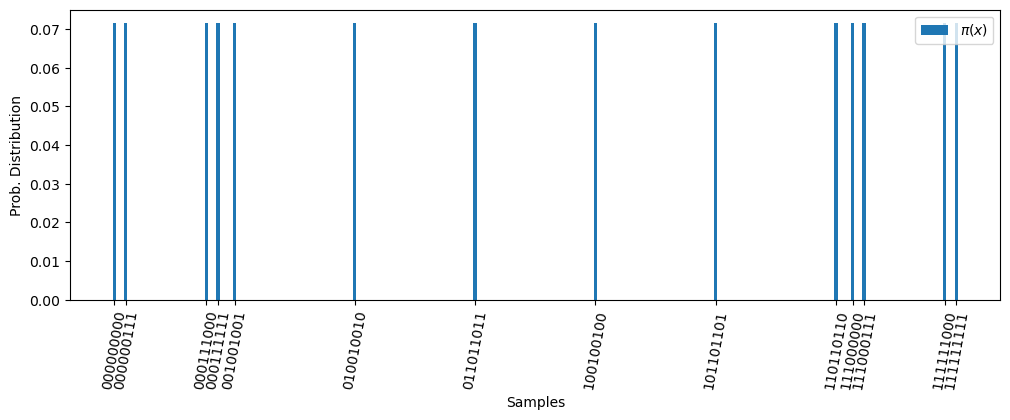

In [6]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

In [7]:
py_psi = np.zeros(2**size,dtype=complex)
amp = 1 / math.sqrt(len(data))
for i in nums:
    py_psi[i] = amp

target_dm = np.outer(py_psi,py_psi.conj())

### Functions

In [29]:
n_qubits = 9
n_ancillas = 9
total_qubits = n_qubits + n_ancillas

class TraceDistanceLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    def tr_distance(self, pxy):
        """
        Compute the trace distance of the difference matrix pxy.
        
        Parameters:
            pxy (numpy.ndarray): Difference of two probability distributions.
        
        Returns:
            float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
        """
        dagger_pxy = pxy.conj().T  # Compute Hermitian conjugate
        return 0.5 * np.trace(np.sqrt(dagger_pxy * pxy))

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        pxy = px - py
        return self.tr_distance(pxy)
    
class QCBM:

    def __init__(self,circ,trdistance,py):
        self.circ = circ
        self.trdistance = trdistance
        self.py = py

    def qcbm_loss(self,params):
        px = self.circ(params)
        loss = self.trdistance(px[0],self.py)
        return np.real(loss)

In [ ]:
# def update_step(params,opt_state):
    
    # loss_val, grads = jax.value_and_grad(qcbm.qcbm_loss,has_aux=False)(params)

    # updates,opt_state = opt.update(grads,opt_state)
    # params = optax.apply_updates(params,updates)
    

#     return params, opt_state, loss_val

def update_step(params):

    params = opt.step(qcbm.qcbm_loss,params)
    loss_val = qcbm.qcbm_loss(params)

    return params, loss_val

In [46]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RZ(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])

    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits,shots=None)


@qml.qnode(dev,interface="autograd")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.density_matrix(wires=range(total_qubits))
    # output2 = qml.density_matrix([(num_qubits+i) for i in range(n_ancillas)])
    return [output1]


### Training the Model

In [11]:
folds = 3
key = jax.random.PRNGKey(0)
initial_params = jax.random.uniform(key, shape=(folds, (3 * total_qubits)), minval=0.0, maxval=1.0)

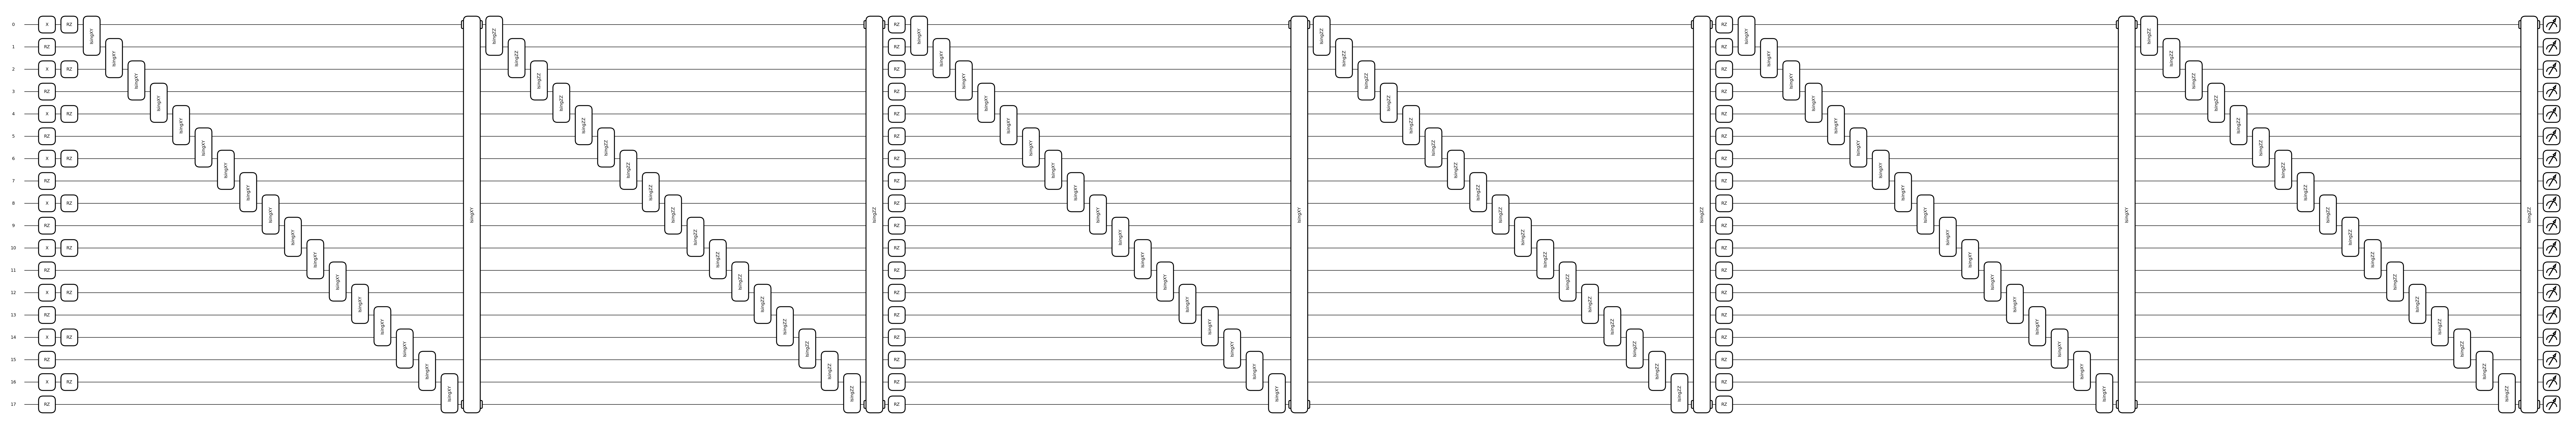

In [28]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [1]:
circuit(initial_params)[0]

NameError: name 'circuit' is not defined

In [26]:
tr_distance = TraceDistanceLoss()
qcbm = QCBM(circuit,tr_distance,target_dm)

weights = initial_params
lr = 1
opt = AdamOptimizer(stepsize=lr)
# opt_state = opt.init(weights)

loss = []
parameters = []
n_epochs = 10
i = 0

while i < n_epochs:

    if i == 0:
        loss_val = qcbm.qcbm_loss(weights)
        loss.append(loss_val)
        parameters.append(weights)

    i += 1
    current_lr = lr
    start_time = time.time()
    weights, loss_val = update_step(params=weights)
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val:.6f} current_lr: {current_lr} Time taken per iter: {end_time-start_time}")

    loss.append(loss_val)
    parameters.append(weights)


Step: 10 Loss: 0.998806 current_lr: 1 Time taken per iter: 0.5181629657745361
